In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, GrowthRateModel
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen
from MIOFlow.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from MIOFlow.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [3]:
#| export
def branch_data_clean(t, e):
    shapes = (len(e), len(t))
    t = t.reshape(1,-1)
    e = e.reshape(-1, 1)
    ts = np.tile(t, (shapes[0], 1))[...,None]
    es = np.tile(e, (1, shapes[1]))[...,None]
    x = np.tile(t, (shapes[0], 1))
    y = e * t**2
    data = np.stack([x,y], axis=2)
    data = np.concatenate((ts, es, data), axis=-1)
    data = data.reshape(shapes[0]*shapes[1], -1)
    return data
def branch_data_data(data, n_colors=5, repeats=5, noisex=0.05, noisey=0.05, seed=32):
    data = np.tile(data, (repeats,1))
    df = pd.DataFrame(data, columns=['t', 'e1', 'd1', 'd2'])
    np.random.seed(seed)
    df['d1'] += np.random.randn(df.shape[0]) * noisex
    df['d2'] += np.random.randn(df.shape[0]) * noisey
    _, bin_edges = np.histogram(df['t'], bins=n_colors)
    bin_indices = np.digitize(df['t'], bin_edges)
    bin_indices[bin_indices > n_colors] = n_colors
    df.insert(0, 'samples', bin_indices)
    df.drop(columns=['t'], inplace=True)
    df.samples -=1
    return df
def make_branch_cond(nt=20, ne=3, n_colors=5, repeats=10, noisex=0.1, noisey=0.1, seed=32):
    t = np.linspace(0,1,nt)
    e = np.linspace(-1,1,ne)
    data = branch_data_clean(t, e)
    df = branch_data_data(data, n_colors, repeats, noisex, noisey, seed)
    return df

df = make_branch_cond(ne=2, repeats=20)

df = df[['samples', 'd1', 'd2', 'e1']]

In [4]:
df

,samples,d1,d2,e1
0,0,-0.034889,0.054968,-1.0
1,0,0.151002,0.029287,-1.0
2,0,0.163355,-0.059603,-1.0
3,0,0.164923,-0.072056,-1.0
4,1,0.288280,-0.067361,-1.0
...,...,...,...,...
795,3,0.932206,0.523483,1.0
796,4,0.930819,0.788406,1.0
797,4,1.034536,0.757093,1.0
798,4,0.839130,0.880604,1.0


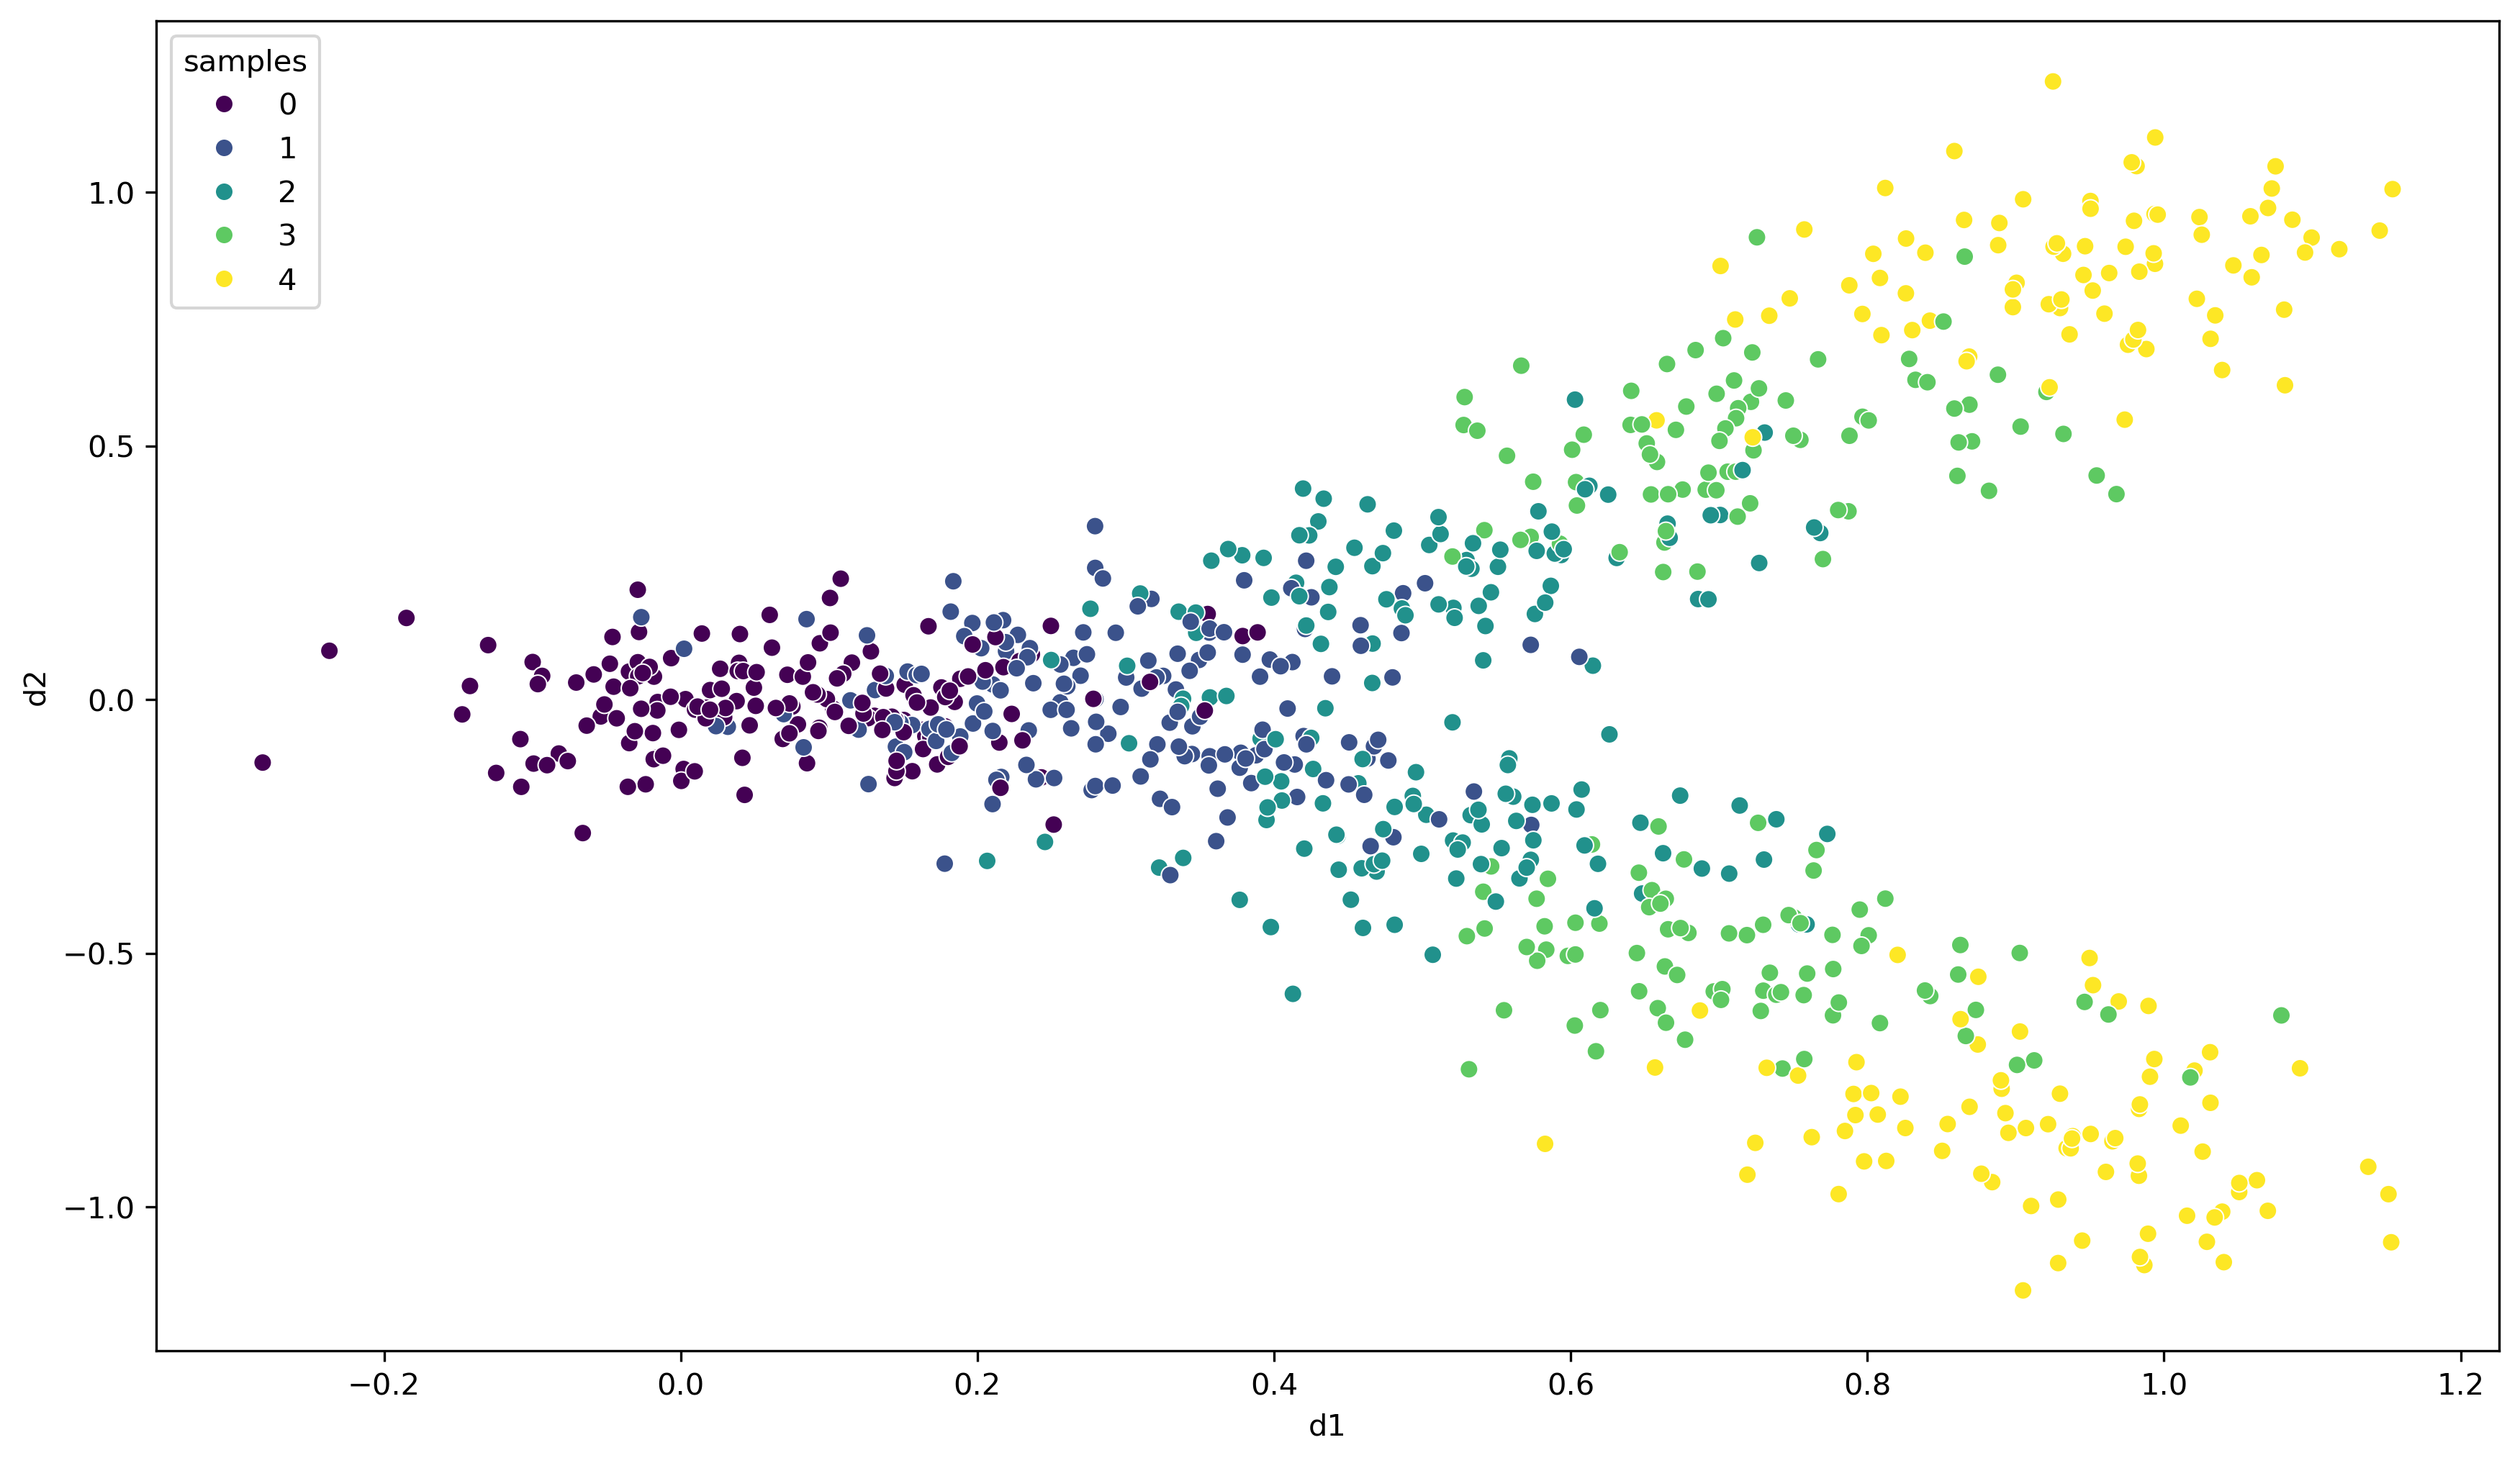

In [5]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

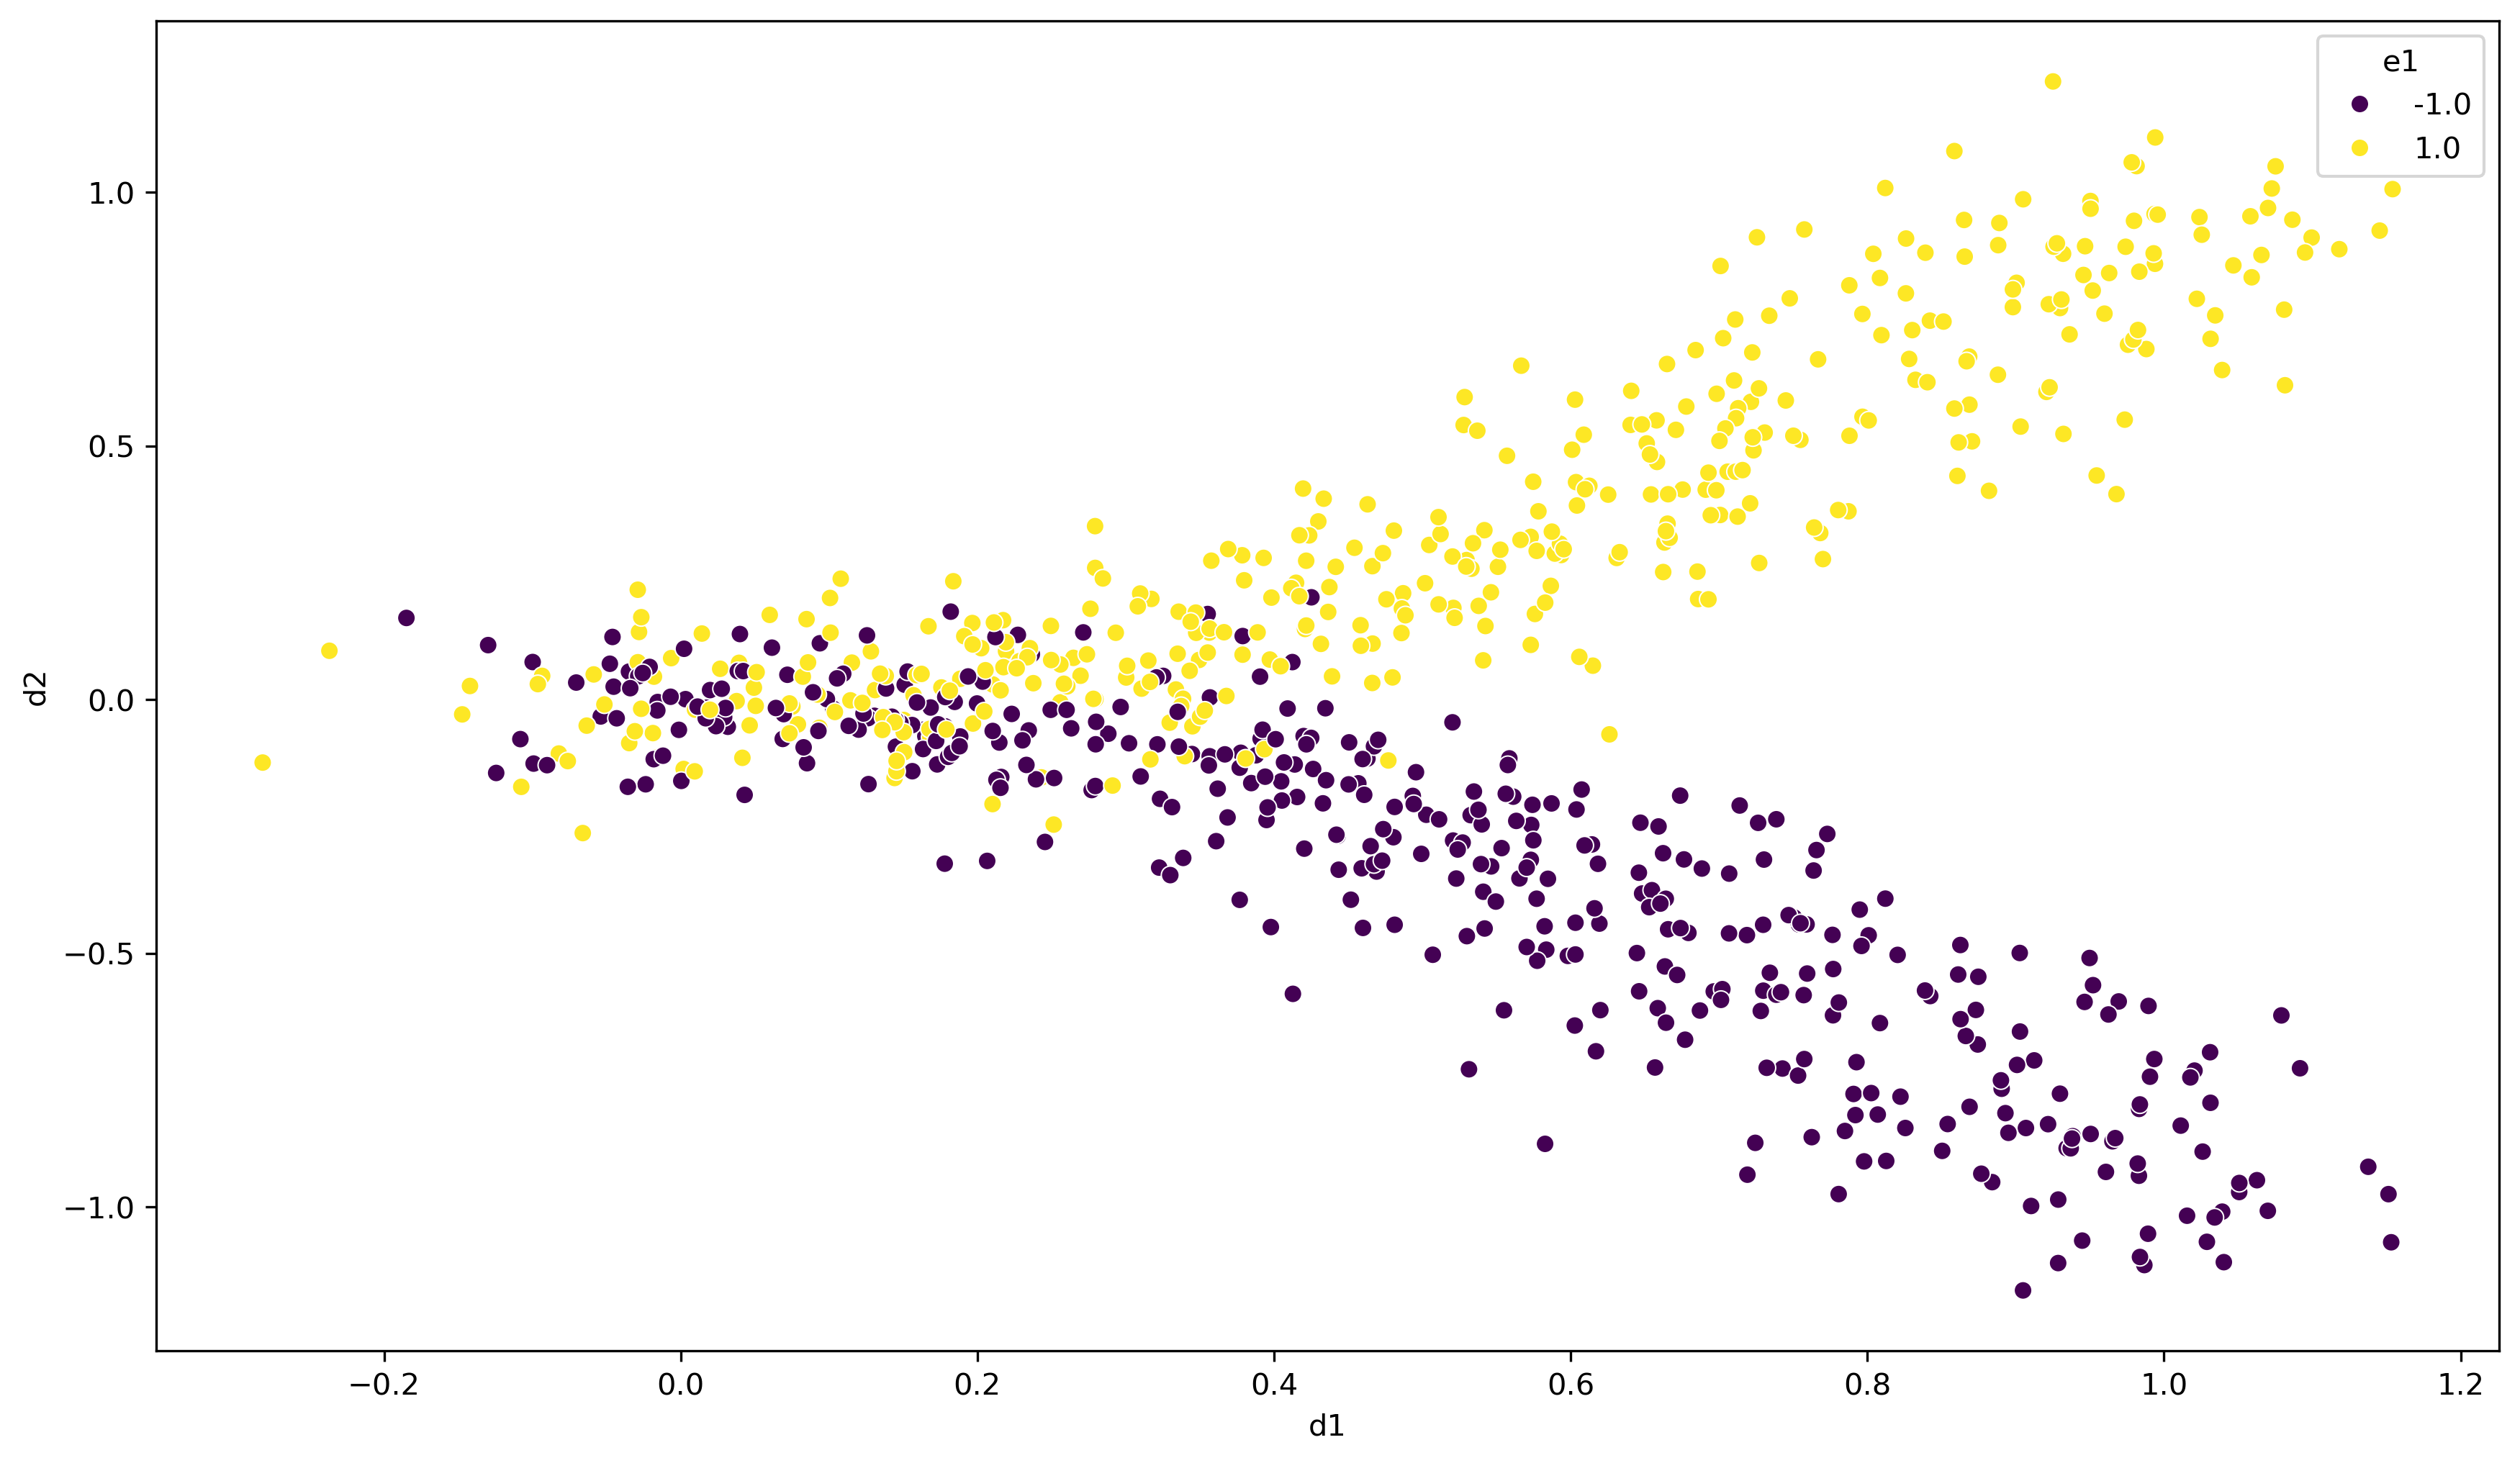

In [6]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='e1', palette='viridis');

In [7]:
df_copy = df.copy()
# df = df.drop(columns=['e1'])

In [8]:
means = df[['d1', 'd2']].mean(axis=0)
stds = df[['d1', 'd2']].std(axis=0)
df[['d1', 'd2']] = (df[['d1', 'd2']] - means) / stds

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [9]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [10]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1 - 1 # drop the condition
groups = sorted(df.samples.unique())

In [11]:
# # These determine the logic flow for training: 
# #   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
# #   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
# #   use_emb=False use_gae=False Is not using the GAE.
# #   use_emb=True use_gae=True, is redundant and should raise an error. 
# use_emb = False
# use_gae = False

# need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# # If the reconstruction loss needs to be computed.
# recon = use_gae and not use_emb 

# # These are training GAE hyperparameters needed for training
# # Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
# distance_type = 'gaussian'
# rbf_length_scale=0.1
# dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale)

# #Can be changed depending on the dataset
# n_epochs_emb = 1000
# samples_size_emb = (30, )

# # Layers for the Geodesic Autoencoder
# gae_embedded_dim = 3
# encoder_layers = [model_features, 8, gae_embedded_dim]

# gae = Autoencoder(
#     encoder_layers = encoder_layers,
#     decoder_layers = encoder_layers[::-1],
#     activation='ReLU', use_cuda = use_cuda
# )
# optimizer = torch.optim.AdamW(gae.parameters())

# Specify parameters

In [12]:
set_seeds(10)

#Directory where results are saved
exp_name = 'test'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
# lambda_density = 35
lambda_density = 0

# For petal=LeakyReLU / dyngen=CELU
activation = 'LeakyReLU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.1] 


# model = make_model(
#     model_features, layers, which='sde', method='euler',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda
# )

# model = make_model(
#     model_features, layers, which='sde', method='reversible_heun', sde_type='stratonovich', adjoint_method='adjoint_reversible_heun',
#     activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=False
# )


model = make_model(
    model_features, layers, which='sde', method='euler', sde_type='ito', 
    activation=activation, scales=sde_scales, use_cuda=use_cuda, use_norm=True, n_conditions=1, momentum_beta=0.5
)

In [13]:
# Basically "batch size"
# sample_size=(60, )
sample_size=(60, )

# Training specification
n_local_epochs = 40
n_epochs = 0
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = True
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name, covariance_lambda=0.0, detach_dist_for_plan=False, detach_mass=False)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [14]:
exp_dir = './results/test_all/'

In [15]:
df

,samples,d1,d2,e1
0,0,-1.664953,0.130430,-1.0
1,0,-1.091340,0.076177,-1.0
2,0,-1.053220,-0.111606,-1.0
3,0,-1.048383,-0.137914,-1.0
4,1,-0.667737,-0.127995,-1.0
...,...,...,...,...
795,3,1.319253,1.120186,1.0
796,4,1.314974,1.679844,1.0
797,4,1.635020,1.613695,1.0
798,4,1.032046,1.874617,1.0


In [16]:
gr_model = GrowthRateModel(
    feature_dims=2,
    condition_dims=1,
    layers=[64,64],
    activation='LeakyReLU',
    use_time=True,
)


In [17]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=0.2,
    # lambda_density=10,
    
    autoencoder=None, use_emb=False, use_gae=False, 
    
    sample_size=sample_size, logger=None,
    reverse_schema=False, reverse_n=reverse_n, # sde cant use reverse schema for now
    # use_penalty=True, 
    use_penalty=True, 
    # lambda_energy=0.001,
    lambda_energy_local = {g:1e-3 for g in groups},
    lambda_energy_global = {g:1e-3 for g in groups},
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
    lambda_cond=1.,
)
# run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
# logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.56151


/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.17921


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.17544


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.08316


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.11416


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.06611


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05025


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.10243


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.09096


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.07193


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.1149


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.14689


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.07742


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05766


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.09657


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.07481


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.00282


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.06222


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.0589


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.09222


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.0713


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05751


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05158


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.07242


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.11359


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.02388


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.0732


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.04892


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.12225


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.07111


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05135


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05657


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.09298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.12337


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.08749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.06132


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.05473


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.12329


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.08135


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 1.04018


Epoch: 0it [00:00, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

In [18]:
model

ConditionalSDEModel(
  (func): ConditionalODE(
    (seq): Sequential(
      (0): Linear(in_features=6, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
  (gunc): ToyODE(
    (seq): Sequential(
      (0): Linear(in_features=5, out_features=16, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=16, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=32, out_features=16, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

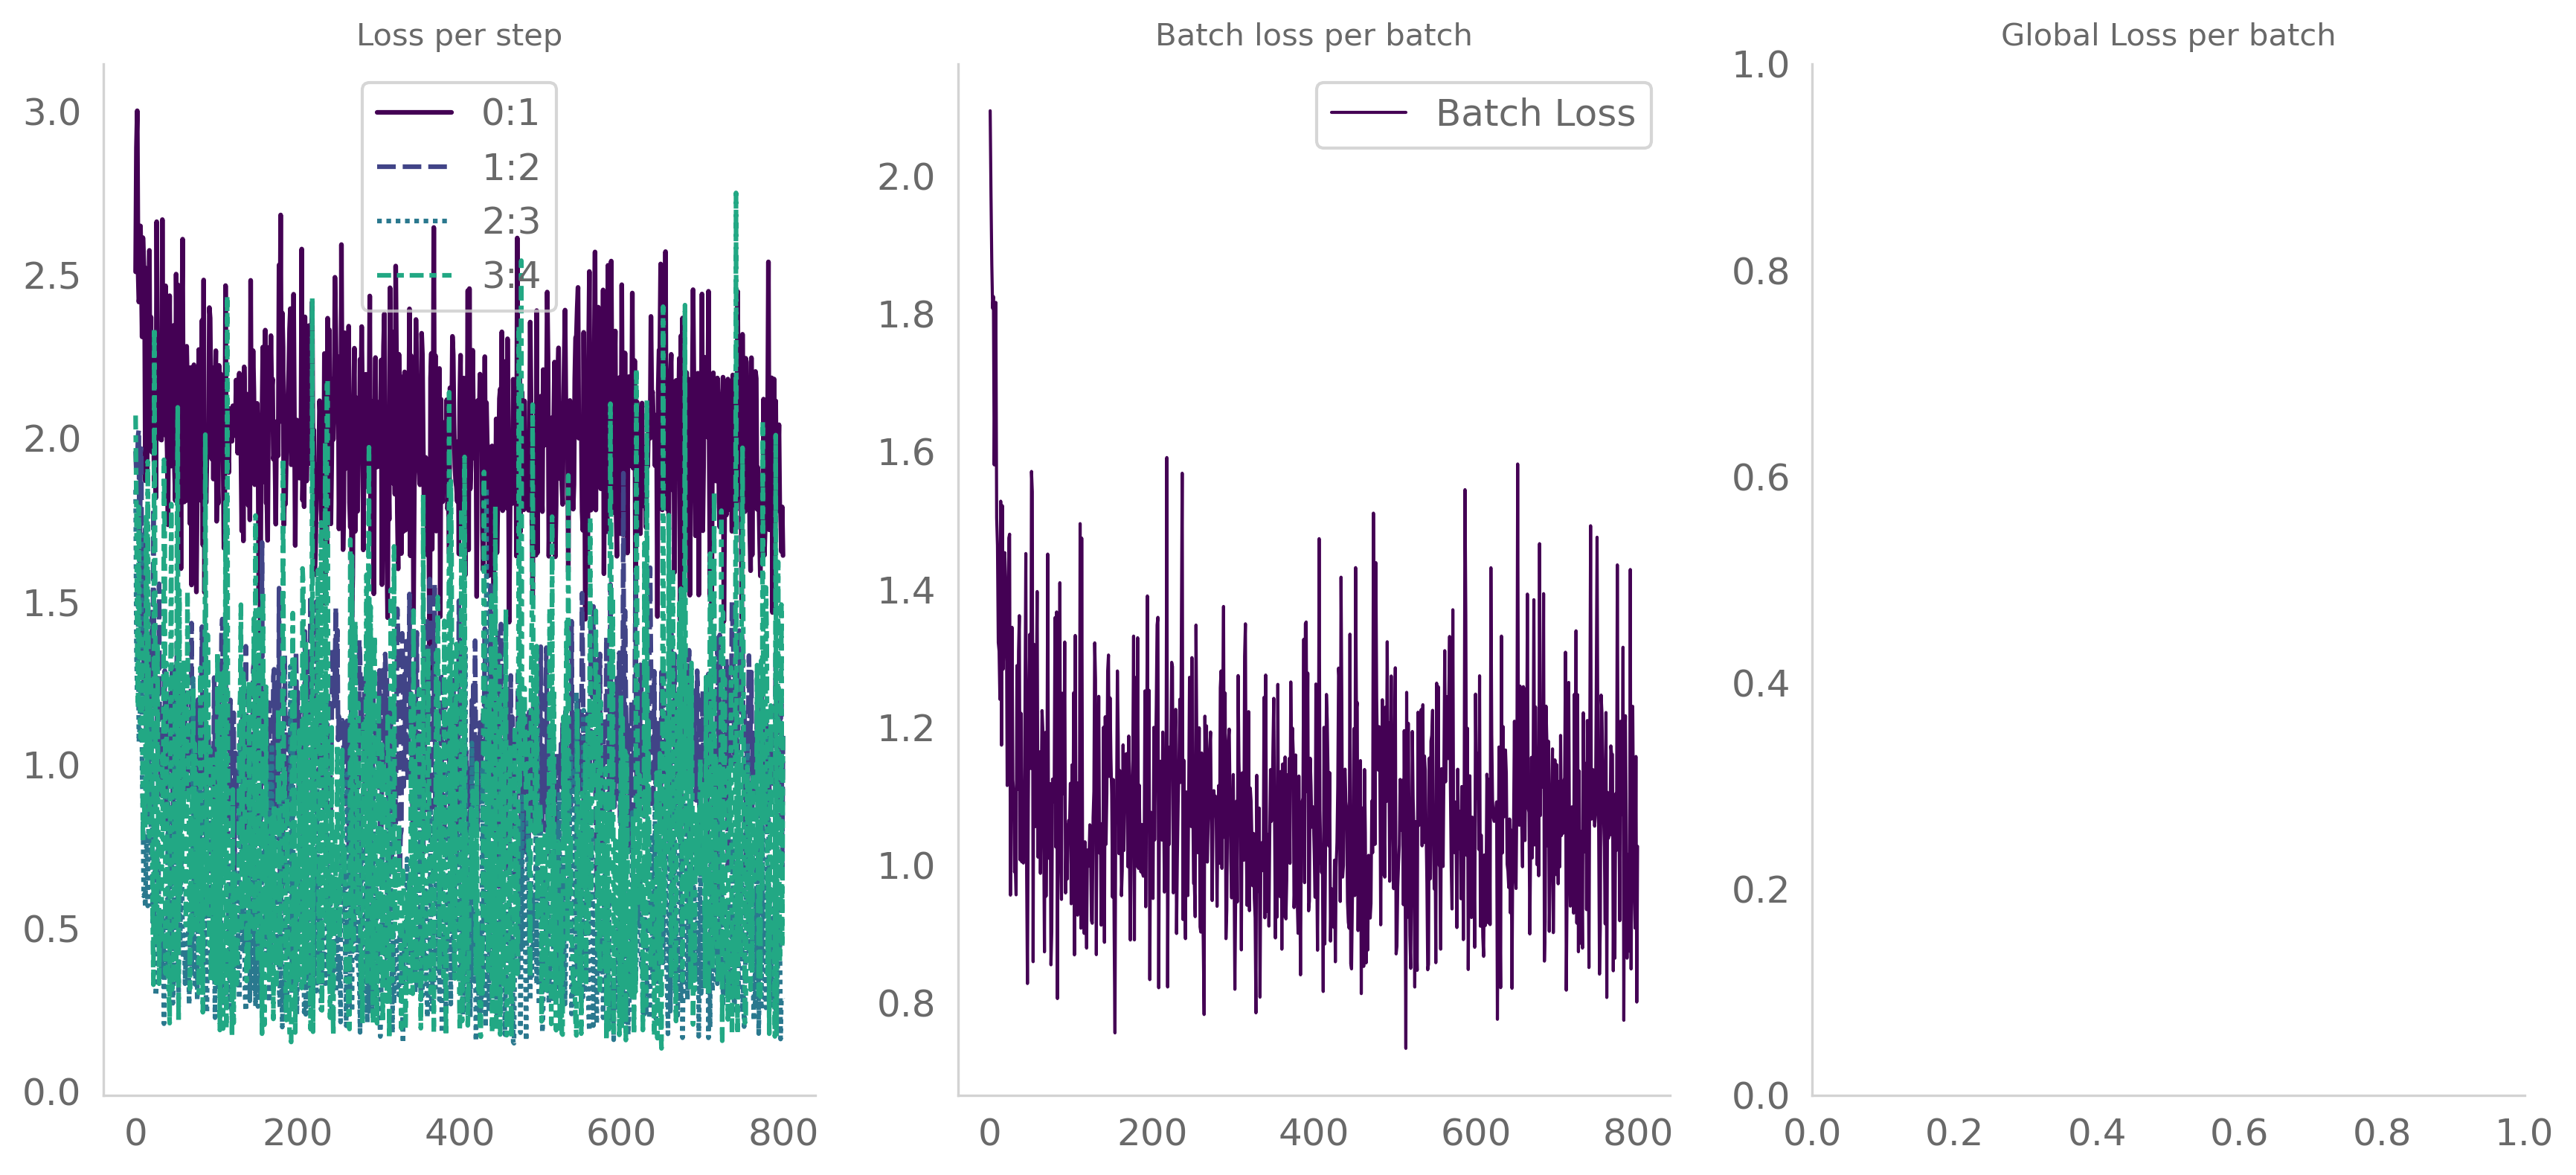

In [19]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [20]:
df

,samples,d1,d2,e1
0,0,-1.664953,0.130430,-1.0
1,0,-1.091340,0.076177,-1.0
2,0,-1.053220,-0.111606,-1.0
3,0,-1.048383,-0.137914,-1.0
4,1,-0.667737,-0.127995,-1.0
...,...,...,...,...
795,3,1.319253,1.120186,1.0
796,4,1.314974,1.679844,1.0
797,4,1.635020,1.613695,1.0
798,4,1.032046,1.874617,1.0


In [21]:
groups

[0, 1, 2, 3, 4]

Text(0.5, 1.0, 'Trajectory')

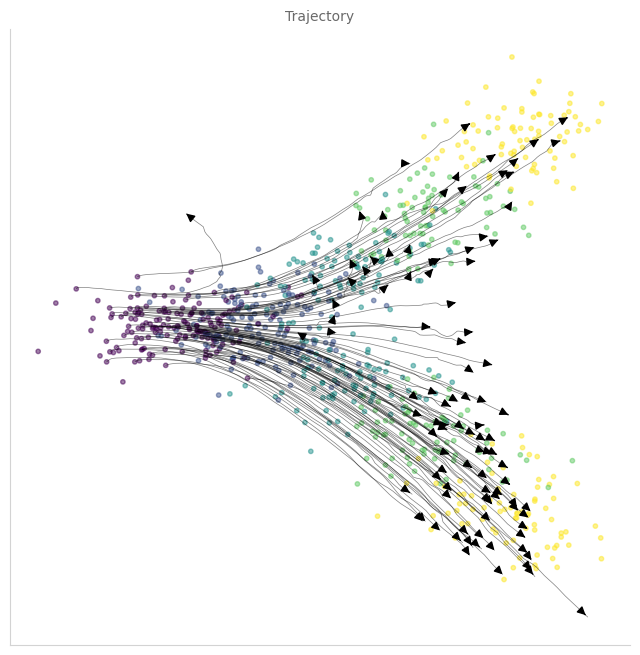

In [23]:
from MIOFlow.utils import sample


data_t0 = sample(df, np.min(groups), replace=False, to_torch=True, use_cuda=use_cuda)

sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)
    # x_trajs.append(x_traj)

fig, ax = plt.subplots(figsize=(8, 8))

scatter = ax.scatter(df['d1'], df['d2'],
                c=df['samples'], cmap='viridis', s=10, alpha=.5)

ax.set_xticks([])
ax.set_yticks([])

for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                    arrowprops=dict(arrowstyle="-|>", color='Black', lw=1))
ax.set_title('Trajectory')

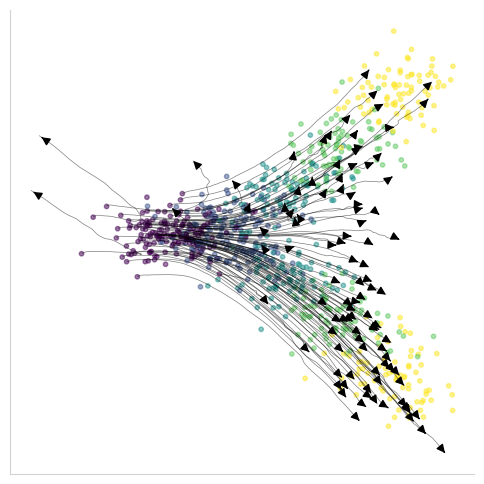

In [24]:
model.eval()
groups = sorted(df['samples'].unique())
sample_time = np.linspace(np.min(groups), np.max(groups), n_bins)
from MIOFlow.utils import sample
np.random.seed(32)
data_t0 = sample(
    df, np.min(groups), size=(n_points, ), 
    replace=False, to_torch=True, use_cuda=use_cuda
)
# data_t0 = torch.tensor([[-1., 0.]], dtype=torch.float32, device='cpu')
fig, ax = plt.subplots(figsize=(5, 5))

sample_time = torch.tensor(sample_time, dtype=data_t0.dtype, device=data_t0.device)

with torch.no_grad():
    x_traj = model(data_t0, sample_time, return_whole_sequence=True)

scatter = ax.scatter(df['d1'], df['d2'],
                c=df['samples'], cmap='viridis', s=10, alpha=.5)

ax.set_xticks([])
ax.set_yticks([])

for i,traj in enumerate(np.transpose(x_traj, axes=(1,0,2))):
    ax.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle="-|>", color='Black', lw=1))

plt.tight_layout()

In [25]:
data_t0

tensor([[-1.0729e+00,  3.2027e-02,  1.0000e+00],
        [-1.6456e+00,  1.1119e-01, -1.0000e+00],
        [-1.6130e+00,  1.0967e-01,  1.0000e+00],
        [-1.4139e+00, -9.3125e-02,  1.0000e+00],
        [-1.9579e+00,  2.4094e-01, -1.0000e+00],
        [-1.0532e+00, -1.1161e-01, -1.0000e+00],
        [-8.0690e-01, -3.0980e-01,  1.0000e+00],
        [-6.9880e-01,  1.7163e-02,  1.0000e+00],
        [-2.4270e+00, -2.4810e-01,  1.0000e+00],
        [-1.4051e+00,  6.3871e-02,  1.0000e+00],
        [-1.6440e+00,  2.9560e-01,  1.0000e+00],
        [-1.5053e+00, -6.3625e-02, -1.0000e+00],
        [-8.2676e-01,  2.0292e-01, -1.0000e+00],
        [-9.2334e-01,  1.3627e-01,  1.0000e+00],
        [-1.8545e+00,  7.8640e-02,  1.0000e+00],
        [-1.6302e+00, -3.3851e-01, -1.0000e+00],
        [-1.9412e+00, -2.9136e-01, -1.0000e+00],
        [-1.3312e+00, -1.2631e-01,  1.0000e+00],
        [-1.4341e+00,  2.8701e-01, -1.0000e+00],
        [-3.5722e-01,  2.9391e-01,  1.0000e+00],
        [-1.7383e+00